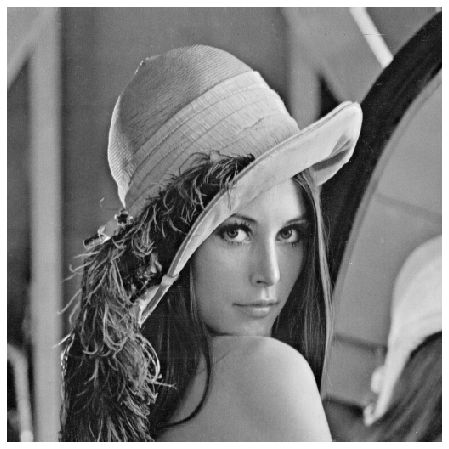

In [1]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import os
plt.rcParams['figure.figsize'] = [16,8]

A = imread('lena.png')
X = np.mean(A, -1)
# X = X[400:500,400:500]

img = plt.imshow(X)
img.set_cmap('gray')
plt.axis('off')
plt.show()

In [2]:
import numpy as np
from numpy.linalg import norm

from random import normalvariate
from math import sqrt


def randomUnitVector(n):
    unnormalized = [normalvariate(0, 1) for _ in range(n)]
    theNorm = sqrt(sum(x * x for x in unnormalized))
    return [x / theNorm for x in unnormalized]


def svd_1d(A, epsilon=1e-10):
    ''' The one-dimensional SVD '''

    n, m = A.shape
    x = randomUnitVector(min(n,m))
    lastV = None
    currentV = x

    if n > m:
        B = np.dot(A.T, A)
    else:
        B = np.dot(A, A.T)

    iterations = 0
    while True:
        iterations += 1
        lastV = currentV
        currentV = np.dot(B, lastV)
        currentV = currentV / norm(currentV)

        if abs(np.dot(currentV, lastV)) > 1 - epsilon:
#             print("converged in {} iterations!".format(iterations))
            return currentV


def svd(A, k=None, epsilon=1e-10):
    '''
        Compute the singular value decomposition of a matrix A
        using the power method. A is the input matrix, and k
        is the number of singular values you wish to compute.
        If k is None, this computes the full-rank decomposition.
    '''
    A = np.array(A, dtype=float)
    n, m = A.shape
    svdSoFar = []
    if k is None:
        k = min(n, m)

    for i in range(k):
        matrixFor1D = A.copy()

        for singularValue, u, v in svdSoFar[:i]:
            matrixFor1D -= singularValue * np.outer(u, v)

        if n > m:
            v = svd_1d(matrixFor1D, epsilon=epsilon)  # next singular vector
            u_unnormalized = np.dot(A, v)
            sigma = norm(u_unnormalized)  # next singular value
            u = u_unnormalized / sigma
        else:
            u = svd_1d(matrixFor1D, epsilon=epsilon)  # next singular vector
            v_unnormalized = np.dot(A.T, u)
            sigma = norm(v_unnormalized)  # next singular value
            v = v_unnormalized / sigma

        svdSoFar.append((sigma, u, v))

    singularValues, us, vs = [np.array(x) for x in zip(*svdSoFar)]
    return singularValues, us.T, vs


(512, 5)
(5, 5)
(5, 512)


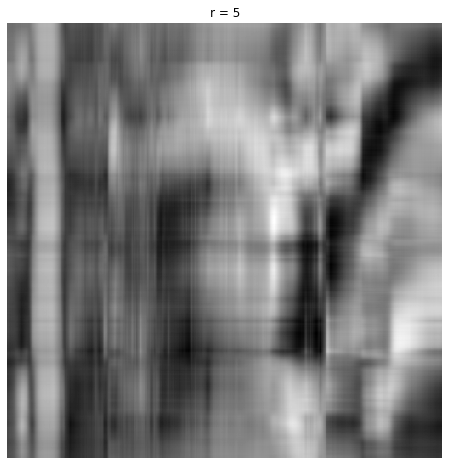

(512, 20)
(20, 20)
(20, 512)


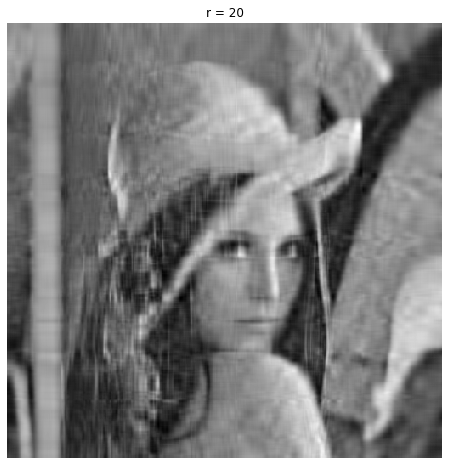

(512, 100)
(100, 100)
(100, 512)


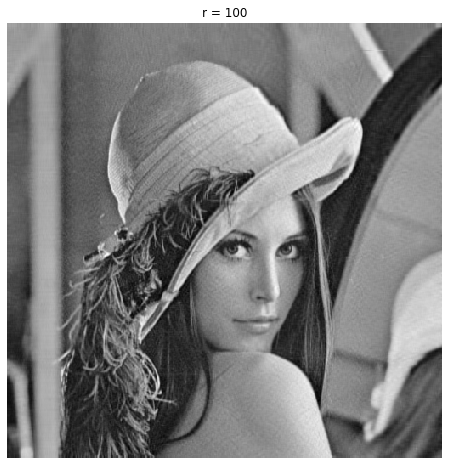

In [ ]:
# S, U, VT = svd(X,20)
# S = np.diag(S)
# print(U.shape)
# print(S.shape)
# print(VT.shape)

j = 0
for r in (5, 20, 100, 1000):
    S, U, VT = svd(X, r)
    S = np.diag(S)
    print(U.shape)
    print(S.shape)
    print(VT.shape)
    Xapprox = U[:, :r] @ S[0:r, :r] @ VT[:r, :]
    plt.figure(j+1)
    j += 1
    img = plt.imshow(Xapprox)
    img.set_cmap('gray')
    plt.axis('off')
    plt.title('r = ' + str(r))
    plt.show()